# HDF-N master catalogue
## Checks and diagnostics

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

import os
import time
import itertools

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
from astropy import visualization as vis
import numpy as np
from matplotlib_venn import venn3

from herschelhelp_internal.masterlist import (nb_compare_mags, nb_ccplots, nb_histograms, 
                                              quick_checks, find_last_ml_suffix)

In [3]:

OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20171016"

master_catalogue_filename = "master_catalogue_hdf-n_{}.fits".format(SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Diagnostics done using: {}".format(master_catalogue_filename))

Diagnostics done using: master_catalogue_hdf-n_20180219.fits


## 0 - Quick checks

In [4]:
quick_checks(master_catalogue).show_in_notebook()

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(156, False) will return an array of dtype('bool')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(156, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


Table shows only problematic columns.


## I - Summary of wavelength domains

In [5]:
flag_obs = master_catalogue['flag_optnir_obs']
flag_det = master_catalogue['flag_optnir_det']

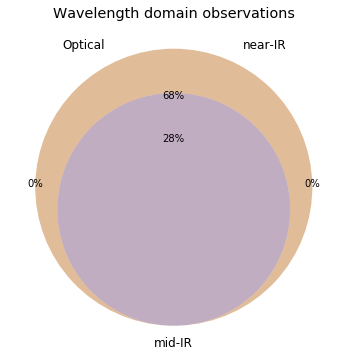

In [6]:
venn3(
    [
        np.sum(flag_obs == 4),
        np.sum(flag_obs == 2),
        np.sum(flag_obs == 6),
        np.sum(flag_obs == 1),
        np.sum(flag_obs == 5),
        np.sum(flag_obs == 3),
        np.sum(flag_obs == 7)
    ],
    set_labels=('Optical', 'near-IR', 'mid-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/len(flag_obs)))
)
plt.title("Wavelength domain observations");

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")


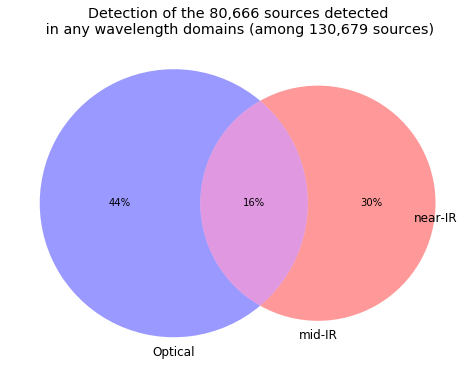

In [7]:
venn3(
    [
        np.sum(flag_det[flag_obs == 7] == 4),
        np.sum(flag_det[flag_obs == 7] == 2),
        np.sum(flag_det[flag_obs == 7] == 6),
        np.sum(flag_det[flag_obs == 7] == 1),
        np.sum(flag_det[flag_obs == 7] == 5),
        np.sum(flag_det[flag_obs == 7] == 3),
        np.sum(flag_det[flag_obs == 7] == 7)
    ],
    set_labels=('mid-IR', 'near-IR', 'Optical'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/np.sum(flag_det != 0)))
)
plt.title("Detection of the {} sources detected\n in any wavelength domains "
          "(among {} sources)".format(
              locale.format('%d', np.sum(flag_det != 0), grouping=True),
              locale.format('%d', len(flag_det), grouping=True)));

## II - Comparing magnitudes in similar filters

The master list if composed of several catalogues containing magnitudes in similar filters on different instruments. We are comparing the magnitudes in these corresponding filters.

In [8]:
u_bands = ["MOSAIC u"]
g_bands = ["GPC1 g"]
r_bands = ["GPC1 r", "SUPRIME r"]
i_bands = ["GPC1 i" ]
z_bands = ["GPC1 z"]
y_bands = ["GPC1 y"]
j_bands = [                                               ]
h_bands = [                                               ]
k_bands = [                                               ]

### II.a - Comparing depths

We compare the histograms of the total aperture magnitudes of similar bands.

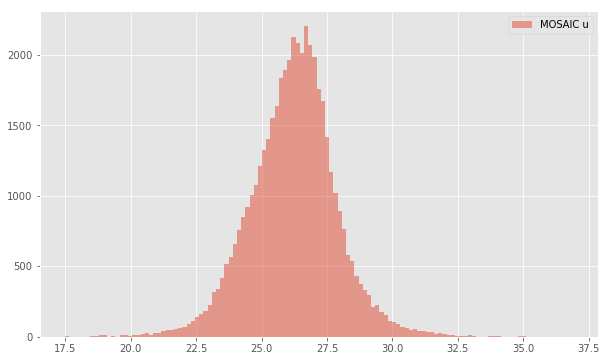

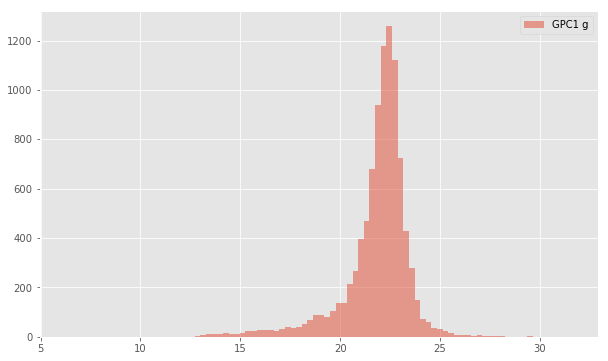

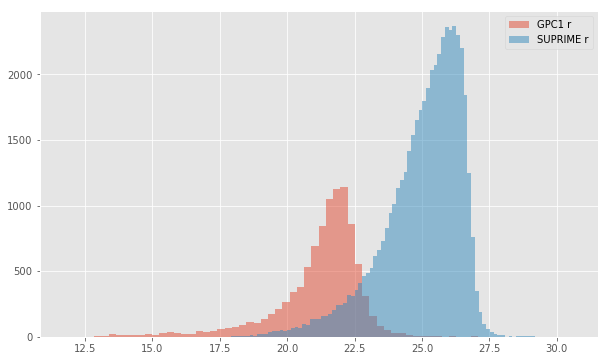

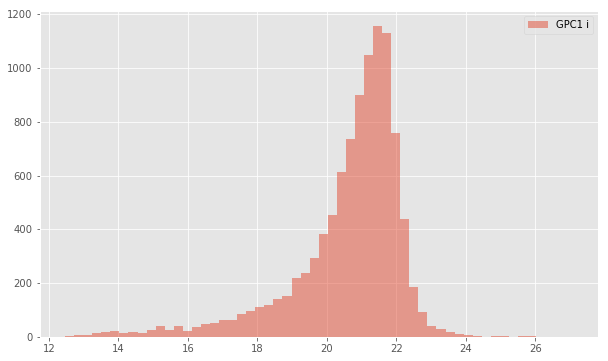

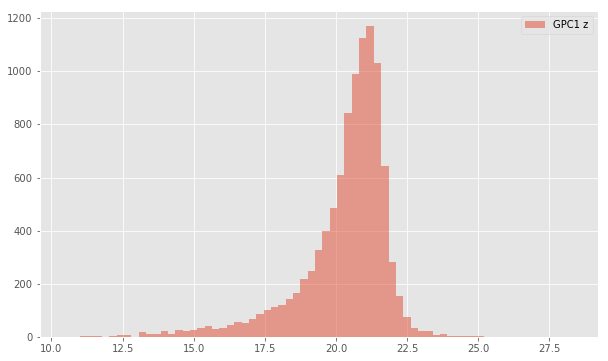

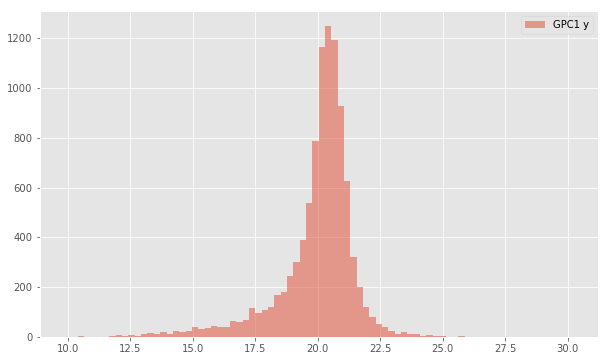

In [9]:
for bands in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands]:
    colnames = ["m_{}".format(band.replace(" ", "_").lower()) for band in bands]
    nb_histograms(master_catalogue, colnames, bands)

### II.b - Comparing magnitudes

We compare one to one each magnitude in similar bands.

SUPRIME r (aperture) - GPC1 r (aperture):
- Median: 0.07
- Median Absolute Deviation: 0.21
- 1% percentile: -1.424673613403319
- 99% percentile: 1.2040346905273431


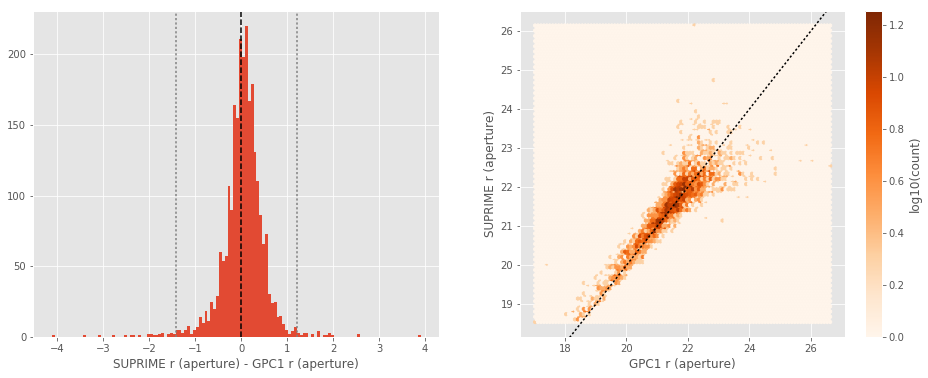

SUPRIME r (total) - GPC1 r (total):
- Median: -0.24
- Median Absolute Deviation: 0.16
- 1% percentile: -1.4006093564038085
- 99% percentile: 1.4649504818432544


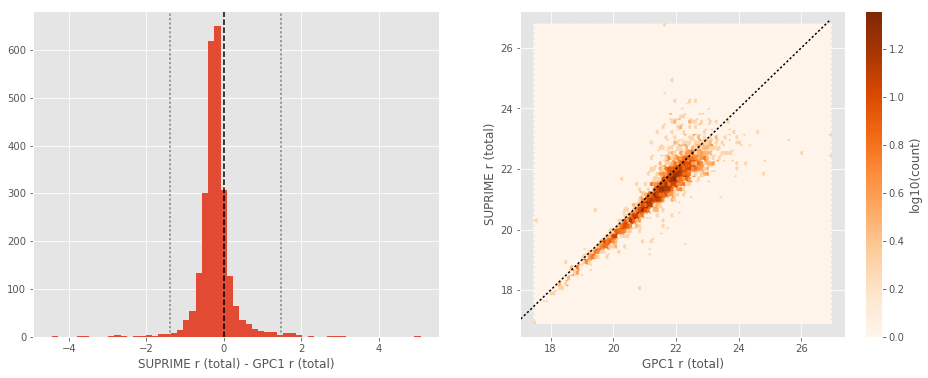

In [10]:
for band_of_a_kind in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands, j_bands, h_bands, k_bands]:
    for band1, band2 in itertools.combinations(band_of_a_kind, 2):
        
        basecol1, basecol2 = band1.replace(" ", "_").lower(), band2.replace(" ", "_").lower()
        
        col1, col2 = "m_ap_{}".format(basecol1), "m_ap_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (aperture)".format(band1), "{} (aperture)".format(band2)))
        
        col1, col2 = "m_{}".format(basecol1), "m_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (total)".format(band1), "{} (total)".format(band2)))

## III - Comparing magnitudes to reference bands

Cross-match the master list to SDSS and 2MASS to compare its magnitudes to SDSS and 2MASS ones.

In [11]:
master_catalogue_coords = SkyCoord(master_catalogue['ra'], master_catalogue['dec'])

### III.a - Comparing u, g, r, i, and z bands to SDSS

The catalogue is cross-matched to SDSS-DR13 withing 0.2 arcsecond. 

We compare the u, g, r, i, and z magnitudes to those from SDSS using `fiberMag` for the aperture magnitude and `petroMag`  for the total magnitude.

In [12]:
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_HDF-N.fits")
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)

idx, d2d, _ = sdss_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

sdss = sdss[mask]
ml_sdss_idx = idx[mask]

MOSAIC u (aperture) - SDSS u (fiberMag):
- Median: -0.15
- Median Absolute Deviation: 0.44
- 1% percentile: -1.7168668045751936
- 99% percentile: 2.942735320161134


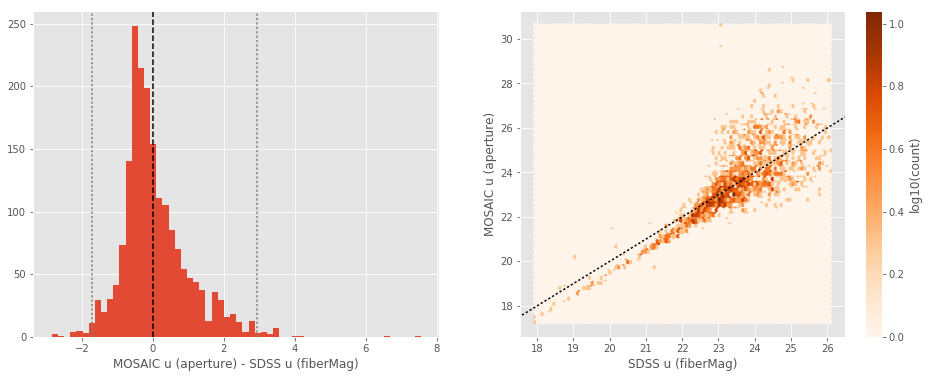

MOSAIC u (total) - SDSS u (petroMag):
- Median: 0.26
- Median Absolute Deviation: 0.67
- 1% percentile: -3.3910033163061515
- 99% percentile: 4.251866573155514


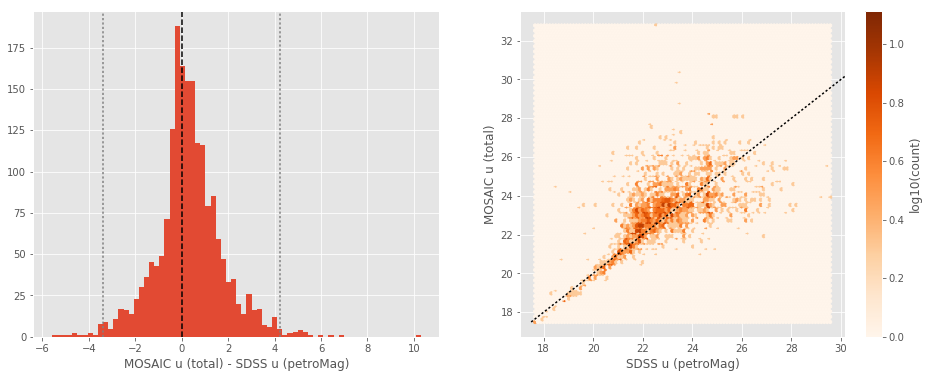

GPC1 g (aperture) - SDSS g (fiberMag):
- Median: -0.60
- Median Absolute Deviation: 0.29
- 1% percentile: -2.5760694885253907
- 99% percentile: 1.7048368072509783


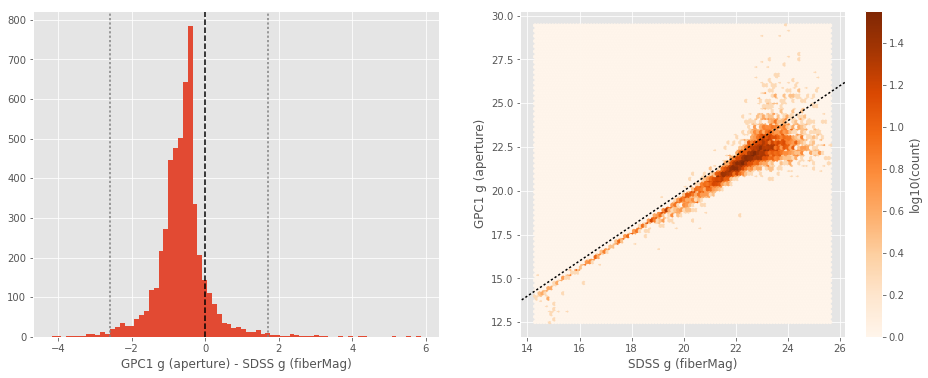

GPC1 g (total) - SDSS g (petroMag):
- Median: -0.08
- Median Absolute Deviation: 0.25
- 1% percentile: -3.9923860931396487
- 99% percentile: 1.4683370971679683


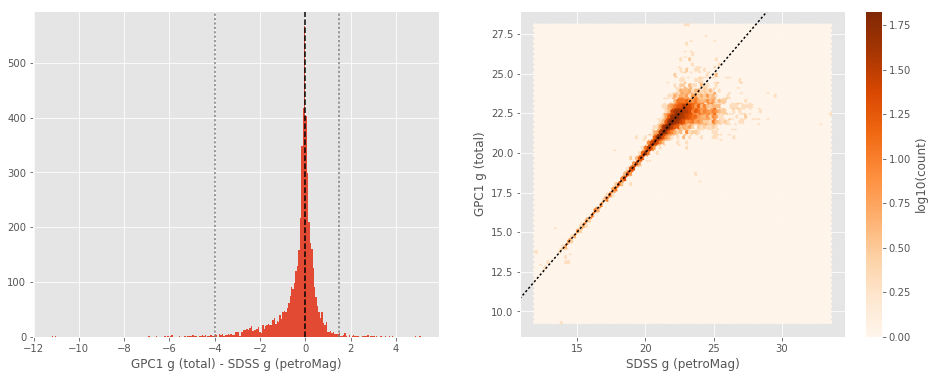

GPC1 r (aperture) - SDSS r (fiberMag):
- Median: -0.47
- Median Absolute Deviation: 0.17
- 1% percentile: -1.4966218566894531
- 99% percentile: 0.9670242309570285


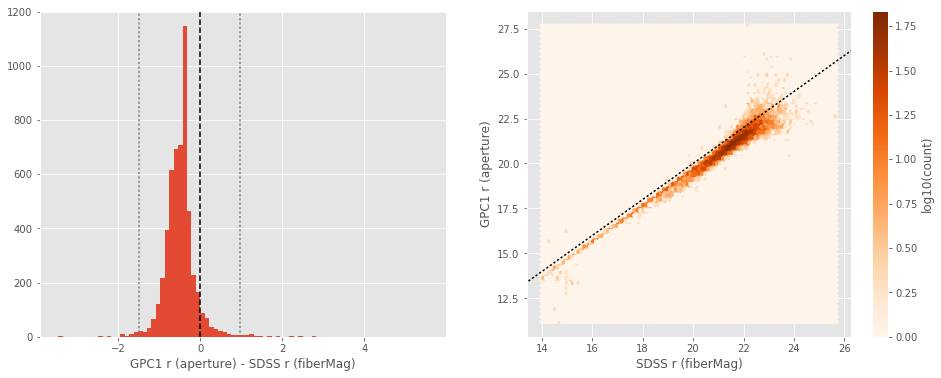

GPC1 r (total) - SDSS r (petroMag):
- Median: 0.03
- Median Absolute Deviation: 0.14
- 1% percentile: -2.213793106079102
- 99% percentile: 1.1340791320800772


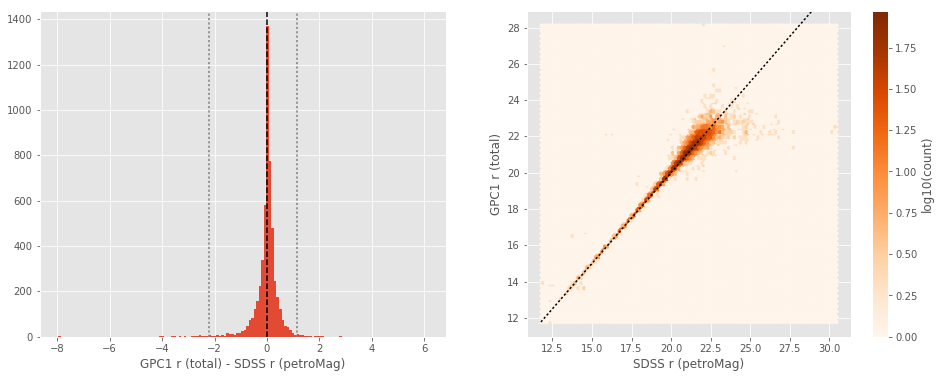

SUPRIME r (aperture) - SDSS r (fiberMag):
- Median: -0.42
- Median Absolute Deviation: 0.11
- 1% percentile: -1.1524517989306626
- 99% percentile: 0.2232965563378855


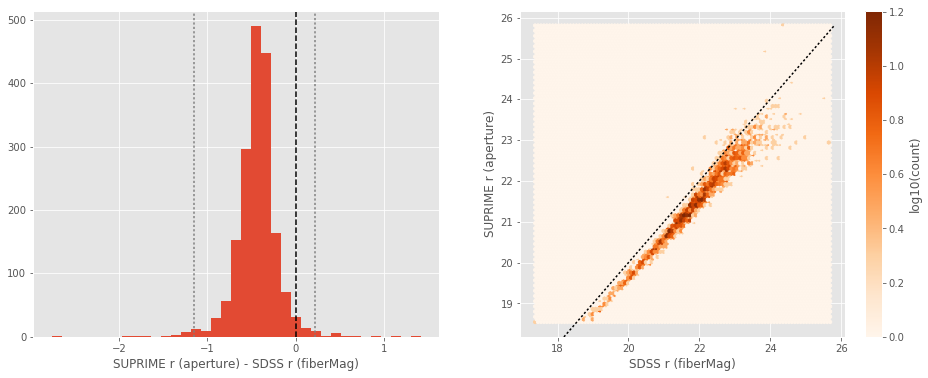

SUPRIME r (total) - SDSS r (petroMag):
- Median: -0.20
- Median Absolute Deviation: 0.19
- 1% percentile: -3.034374487626954
- 99% percentile: 1.0472558652038568


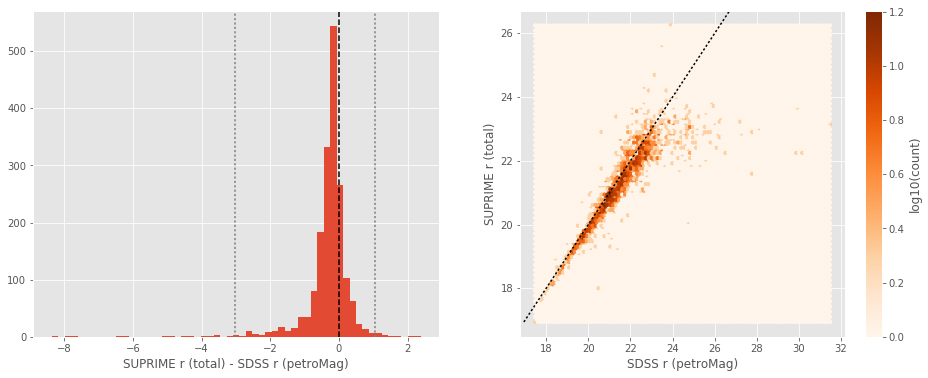

GPC1 i (aperture) - SDSS i (fiberMag):
- Median: -0.44
- Median Absolute Deviation: 0.12
- 1% percentile: -1.1171233367919922
- 99% percentile: 0.2286124420166025


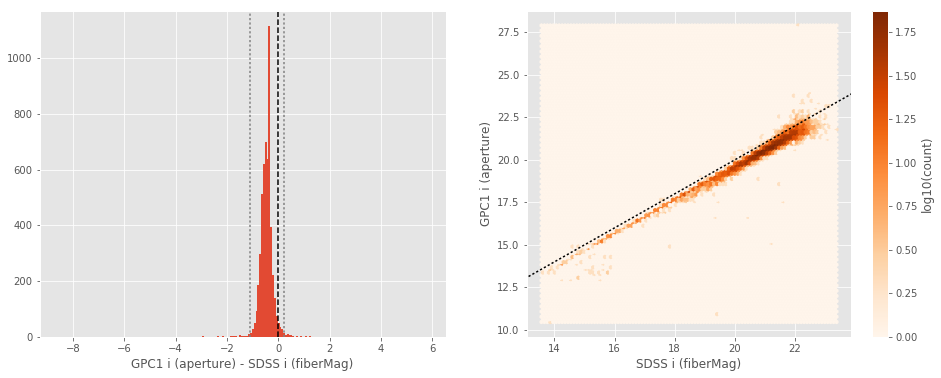

GPC1 i (total) - SDSS i (petroMag):
- Median: 0.06
- Median Absolute Deviation: 0.12
- 1% percentile: -2.0888433837890625
- 99% percentile: 0.9435255050659161


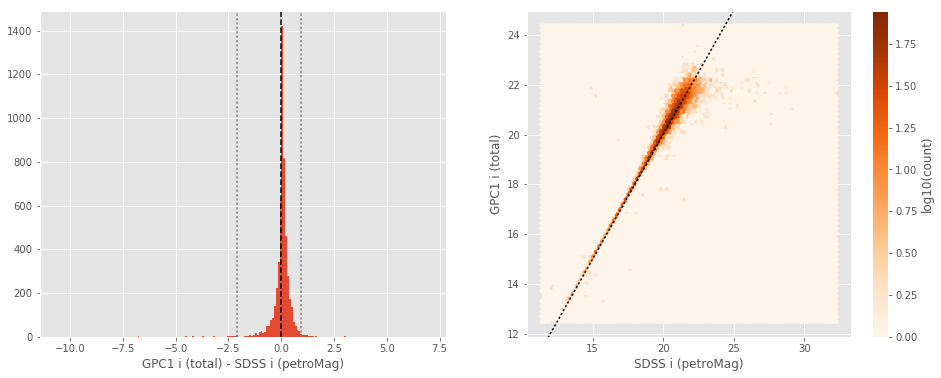

GPC1 z (aperture) - SDSS z (fiberMag):
- Median: -0.36
- Median Absolute Deviation: 0.18
- 1% percentile: -1.5850920677185059
- 99% percentile: 0.7624429321289085


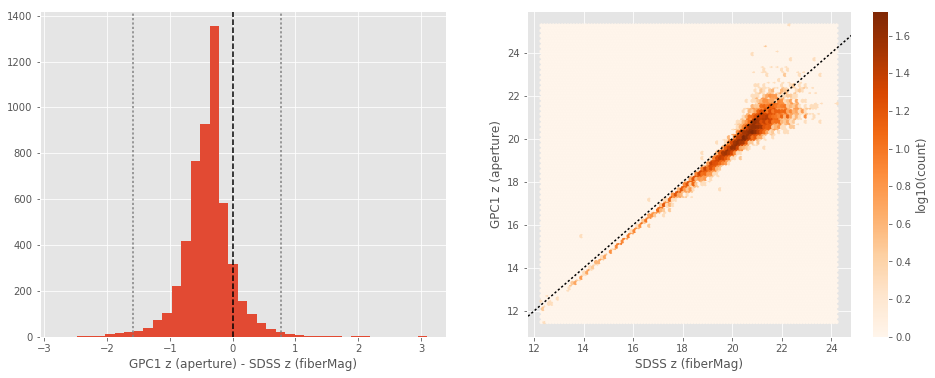

GPC1 z (total) - SDSS z (petroMag):
- Median: 0.10
- Median Absolute Deviation: 0.30
- 1% percentile: -4.0788907623291015
- 99% percentile: 1.606949920654297


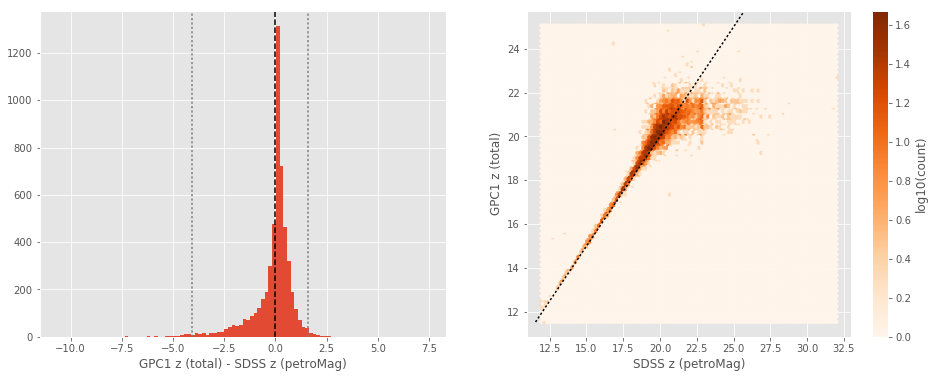

In [13]:
for band_of_a_kind in [u_bands, g_bands, r_bands, i_bands, z_bands]:
    for band in band_of_a_kind:
        
        sdss_mag_ap = sdss["fiberMag_{}".format(band[-1])]
        master_cat_mag_ap = master_catalogue["m_ap_{}".format(band.replace(" ", "_").lower())][ml_sdss_idx]
    
        nb_compare_mags(sdss_mag_ap, master_cat_mag_ap,
                        labels=("SDSS {} (fiberMag)".format(band[-1]), "{} (aperture)".format(band)))
    
        sdss_mag_tot = sdss["petroMag_{}".format(band[-1])]
        master_cat_mag_tot = master_catalogue["m_{}".format(band.replace(" ", "_").lower())][ml_sdss_idx]
        
        nb_compare_mags(sdss_mag_tot, master_cat_mag_tot,
                        labels=("SDSS {} (petroMag)".format(band[-1]), "{} (total)".format(band)))

### III.b - Comparing J and K bands to 2MASS

The catalogue is cross-matched to 2MASS-PSC withing 0.2 arcsecond. We compare the UKIDSS total J and K magnitudes to those from 2MASS.

The 2MASS magnitudes are “*Vega-like*” and we have to convert them to AB magnitudes using the zero points provided on [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html):

| Band | Fν - 0 mag (Jy) |
|------|-----------------|
| J    | 1594            |
| H    | 1024            |
| Ks   | 666.7           |

In addition, UKIDSS uses a K band whereas 2MASS uses a Ks (“short”) band, [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4b.html) give a correction to convert the K band in a Ks band with the formula:

$$K_{s(2MASS)} = K_{UKIRT} + 0.003 + 0.004 * (J−K)_{UKIRT}$$

In [14]:
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1595)
k_2mass_to_ab = 2.5 * np.log10(3631/666.7)

In [15]:
twomass = Table.read("../../dmu0/dmu0_2MASS-point-sources/data/2MASS-PSC_XMM-LSS.fits")
twomass_coords = SkyCoord(twomass['raj2000'], twomass['dej2000'])

idx, d2d, _ = twomass_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

twomass = twomass[mask]
ml_twomass_idx = idx[mask]

In [16]:
nb_compare_mags(twomass['kmag'] + k_2mass_to_ab, master_catalogue['m_wircam_ks'][ml_twomass_idx],
                labels=("2MASS Ks", "WIRCAM Ks (total)"))

No sources have both 2MASS Ks and WIRCAM Ks (total) values.


## IV - Comparing aperture magnitudes to total ones.

Number of source used: 682 / 130679 (0.52%)
Number of source used: 12017 / 130679 (9.20%)


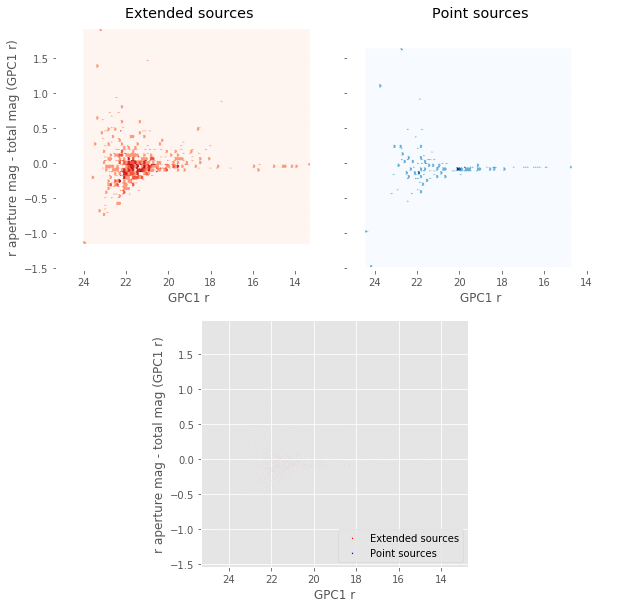

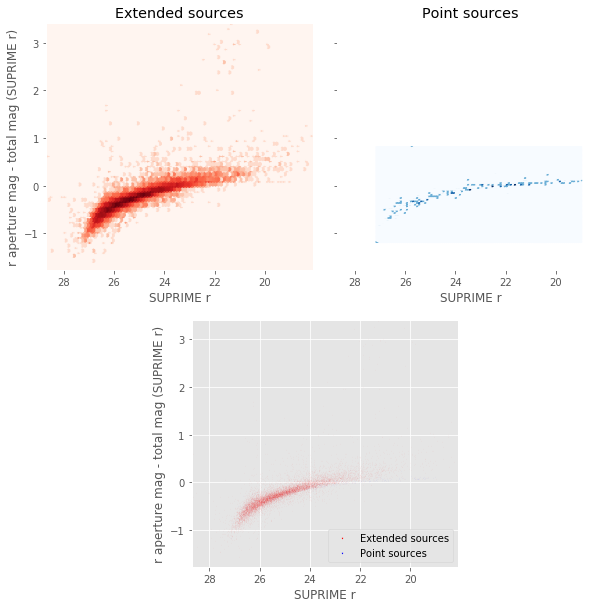

In [17]:
for band in r_bands:
    nb_ccplots(
        master_catalogue["m_{}".format(band.replace(" ", "_").lower())],
        master_catalogue["m_ap_{}".format(band.replace(" ", "_").lower())] - master_catalogue["m_{}".format(band.replace(" ", "_").lower())],
        band, "r aperture mag - total mag ({})".format(band),
        master_catalogue["stellarity"],
        invert_x=True
    )

## V - Color-color and magnitude-color plots

Number of source used: 374 / 130679 (0.29%)


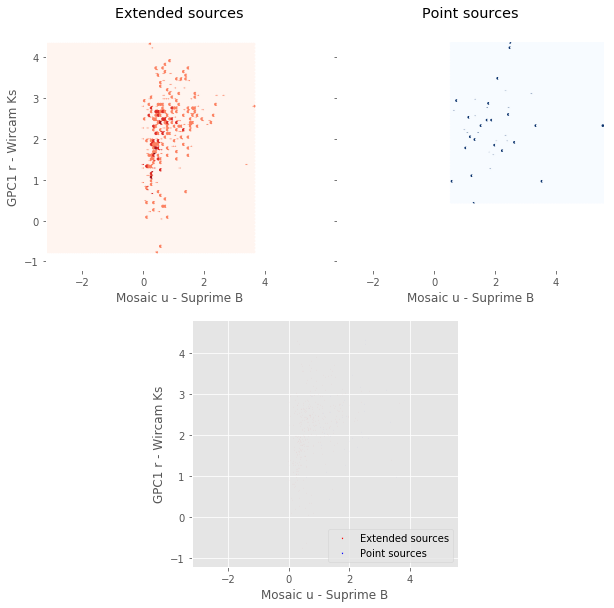

In [18]:
nb_ccplots(
    master_catalogue['m_mosaic_u'] - master_catalogue['m_suprime_b'],
    master_catalogue['m_gpc1_r'] - master_catalogue['m_wircam_ks'],
    "Mosaic u - Suprime B", "GPC1 r - Wircam Ks",
    master_catalogue["stellarity"]
)

Number of source used: 640 / 130679 (0.49%)


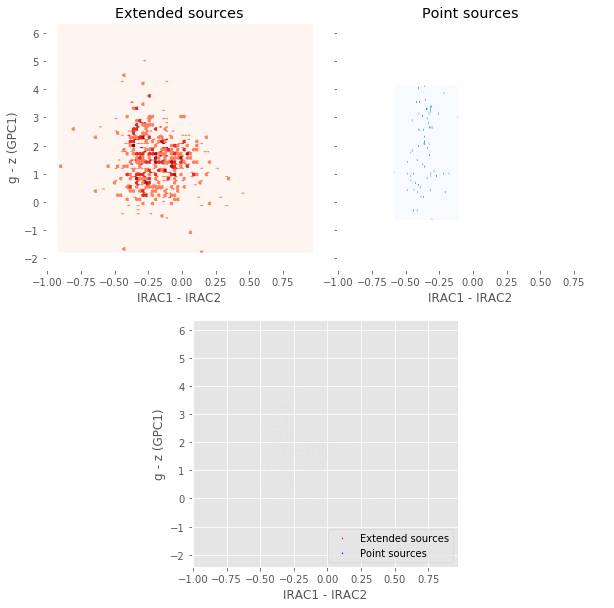

In [19]:
nb_ccplots(
    master_catalogue['m_irac_i1'] - master_catalogue['m_irac_i2'],
    master_catalogue['m_gpc1_g'] - master_catalogue['m_gpc1_z'],
    "IRAC1 - IRAC2", "g - z (GPC1)",
    master_catalogue["stellarity"]
)